In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importaciones de DSO (Deep Symbolic Optimization)
# Esto funcionará si la instalación (Paso 2) fue exitosa
from dso import DeepSymbolicRegressor 

# Importaciones de sklearn y evaluación
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

print("Importaciones de DSO (sklearn) exitosas.")

# --- Funciones de Datos y Evaluación ---

def generate_nguyen_data(func_id, n_samples=512):
    """
    Genera dataset sintético.
    """
    rng = np.random.default_rng()
    if func_id == 1:
        f = lambda x: x**3 + x**2 + x
        dim = 1
    elif func_id == 5:
        f = lambda x: np.sin(x**2)*np.cos(x) - 1
        dim = 1
    # ... (otras funciones)
    else:
        raise ValueError("func_id no soportado.")

    X = rng.uniform(-1, 1, size=(n_samples, dim))

    if dim == 1:
        y = f(X[:, 0])
        
    # La versión TF1 de DSO usa float32
    return X.astype(np.float32), y.reshape(-1, 1).astype(np.float32), dim


def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Calcula NRMSE y R² en train/test.
    """
    # El README.md muestra que el modelo tiene .predict()
    y_pred_train = model.predict(X_train) 
    y_pred_test = model.predict(X_test)

    y_pred_train = y_pred_train.reshape(-1)
    y_pred_test = y_pred_test.reshape(-1)
    y_train_flat = y_train.reshape(-1)
    y_test_flat = y_test.reshape(-1)

    def nrmse(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        denom = np.max(y_true) - np.min(y_true)
        return rmse / denom if denom != 0 else rmse

    metrics = {
        "NRMSE_train": nrmse(y_train_flat, y_pred_train),
        "NRMSE_test": nrmse(y_test_flat, y_pred_test),
        "R2_train": r2_score(y_train_flat, y_pred_train),
        "R2_test": r2_score(y_test_flat, y_pred_test),
    }
    return metrics


def plot_nguyen_fit(func_id, model, metrics=None, x_range=(-2, 2), n_points=400):
    """
    Grafica la función real y la predicha por el modelo DSO (DSR).
    """
    dim = 1
    x = np.linspace(x_range[0], x_range[1], n_points).astype(np.float32)
    
    if func_id == 1:
        f_true = x**3 + x**2 + x
    elif func_id == 5:
        f_true = np.sin(x**2)*np.cos(x) - 1

    X_plot = x.reshape(-1, 1)
    # El README.md muestra que el modelo tiene .predict()
    f_pred = model.predict(X_plot).flatten() 

    r2_val = metrics["R2_test"] if metrics else 0.0

    plt.figure(figsize=(8,4))
    plt.plot(x, f_true, label="Función real", linewidth=2, color='C0')
    plt.plot(x, f_pred, '--', label="Predicha (DSO)", linewidth=2, color='C1')
    plt.xlabel("x", fontsize=12)
    plt.ylabel("y", fontsize=12)
    plt.title(f"Nguyen-{func_id} | R²_test = {r2_val:.3f}",
              fontsize=14, weight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

Importaciones de DSO (sklearn) exitosas.


Entrenando DSO (DSR) para Nguyen-1...
-- BUILDING PRIOR START -------------
LengthConstraint: Sequences have minimum length 4.
                  Sequences have maximum length 64.
NoInputsConstraint: Sequences contain at least one input variable Token.
UniformArityPrior: Activated.
SoftLengthPrior: No description available.
RepeatConstraint: [poly] cannot occur more than 1 times.
-- BUILDING PRIOR END ---------------

-- RUNNING ITERATIONS START -------------
[00:00:00:02.21] Training iteration 1, current best R: 1.0000

	** New best
	Reward: 0.9999999521189645
	Count Off-policy: 0
	Count On-policy: 1
	Originally on Policy: True
	Invalid: False
	Traversal: add,add,-8.0*x1+1.0*x1**2+1.0*x1**3,add,add,x1,add,x1,add,x1,x1,add,x1,add,add,x1,x1,x1,x1
	Expression:
	        3         2     
	  1.0⋅x₁  + 1.0⋅x₁  + x₁

[00:00:00:02.49] Early stopping criteria met; breaking early.
Entrenamiento completado.

--- Resultados DSO (DSR) Nguyen-1 ---
Fórmula recuperada:       3         2     
1.0⋅x₁  +

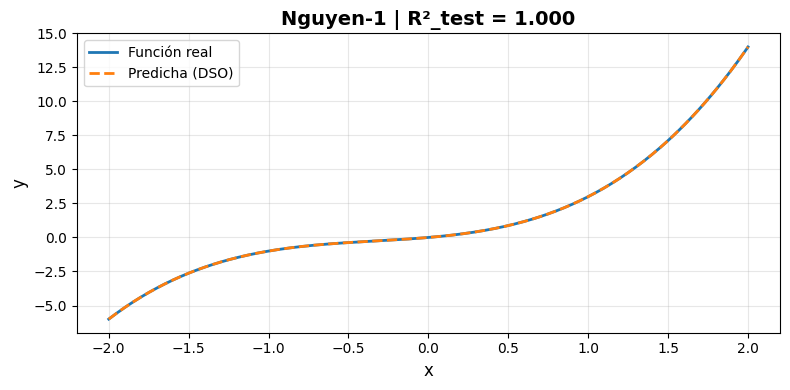

In [4]:
# ---- Configuración ----
FUNC_ID = 1
SEED = 42
np.random.seed(SEED) 

# ---- Generar Datos ----
# El README.md usa np.random para generar datos
X, y, dim = generate_nguyen_data(FUNC_ID, n_samples=512)
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.3, random_state=SEED)

# ---- Configurar DSO (DSR) ----
# El README.md muestra cómo pasar una ruta de config JSON
model_ng1 = DeepSymbolicRegressor("config_ng1.json")

# ---- Entrenar Modelo ----
print(f"Entrenando DSO (DSR) para Nguyen-{FUNC_ID}...")
# El README.md muestra el método .fit()
model_ng1.fit(X_train, y_train) 
print("Entrenamiento completado.")

# ---- Evaluar y Mostrar Resultados ----
# El README.md muestra cómo imprimir la fórmula
formula = model_ng1.program_.pretty() 
metrics = evaluate_model(model_ng1, X_train, y_train, X_test, y_test)

print("\n--- Resultados DSO (DSR) Nguyen-1 ---")
print(f"Fórmula recuperada: {formula}")
print(f"Métricas: {metrics}")

# ---- Graficar ----
plot_nguyen_fit(FUNC_ID, model_ng1, metrics)